## Read data into pandas

In [12]:
%matplotlib inline
import pandas as pd
data = pd.read_json('data/all_reviews.json')

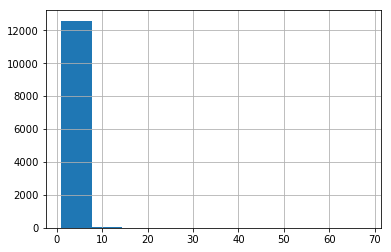

In [15]:
data.groupby('author_name')['place_id'].count().sort_values(ascending=False).hist()

## Clean text

The text data isn't clean

In [2]:
data.text.values[:5]

array(['Always quiet. Always open. Usually pleasant staff. ',
       'The food is decent and cheap but the employees are less than helpful.',
       'Great place on Queens Boulevard for after-work get-togethers',
       "The owner's wife has been (and still is) a long-time client of my mom, and my mom frequents here for special occasions/family dinners. It was my first time going there and the owner + wife couldn't be nicer people to me, my mom + family. Phenomenal service, along with the food + quality. \n\n10/10 would dine here again.",
       "Stellar / top notch Middle Eastern cuisine.   I believe the owner is Syrian because the flavorings and sauces have a Syrian spin to them.\n\nThe  Magic Combination for one is a stupendous value.   You'll be bursting at the seams for $17.  Honestly, I don't know how a human being can consume all that food.\n\nI saw people eating schwarma sandwiches which looked and smelled divine.\n\nHighly recommended."], dtype=object)

Start by loading spacy and its corpus

In [3]:
import spacy
nlp = spacy.load('en')

Write a function that lemmatize and removes stop words, punctuation, numbers, etc.

In [4]:
NUMBERS = [str(n) for n in range(0, 10)]
def clean(s):
    clean_text = []
    for w in nlp(s):
        if not w.is_stop and not w.is_punct and not any(n in str(w) for n in NUMBERS):
            clean_text.append(w.lemma_.lower())
    return ' '.join(clean_text)

Apply function to the text data

In [5]:
text = data.text.tolist()
text = [t.lower() for t in text]
clean_text = [clean(s) for s in text]
data['text'] = clean_text
data.text.values[:5]

array(['quiet open usually pleasant staff',
       'food decent cheap employee helpful',
       'great place queen boulevard work togethers',
       "owner 's wife long time client mom mom frequent special occasions/family dinner time go owner + wife not nice people mom + family phenomenal service food + quality \n\n dine",
       'stellar notch middle eastern cuisine    believe owner syrian flavoring sauce syrian spin \n\n   magic combination stupendous value    will burst seam $   honestly not know human consume food \n\n see people eat schwarma sandwich look smell divine \n\n highly recommend'], dtype=object)

## Modeling model

Create a pipeline to vectorize the text data and run it through random forest classification. Use term frequency - inverse document frequency to conver the text to a function of its occurence in each review and occurence in all reviews.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

pipeline = Pipeline([
    ('vectorizer',  TfidfVectorizer(max_df=0.5, ngram_range=(1,4), norm='l2', stop_words='english')),
    ('classifier',  RandomForestClassifier(n_estimators=10))
])

Split data into training and test set

In [7]:
rs = ShuffleSplit(n_splits=1, train_size=0.7, test_size=0.3, random_state=0)
training_idx, testing_idx = next(rs.split(data))
print(len(training_idx), len(testing_idx))
training_data, testing_data = data.iloc[training_idx], data.iloc[testing_idx]

11127 4770


Fit model to data

In [8]:
pipeline.fit(training_data['text'].values, training_data.michelin_stars.values)

Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=Tr...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

## Checking performance of model

In [11]:
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score

predictions = pipeline.predict(testing_data.text.values)
print('Total reviews classified:', len(training_data))
print('Score:', f1_score(testing_data.michelin_stars, predictions, pos_label=0, average='weighted', labels=[0,1,2,3]))
print('Confusion matrix:\n', confusion_matrix(testing_data.michelin_stars, predictions))

Total reviews classified: 11127
Score: 0.974530276061
Confusion matrix:
 [[4683    2    1    0]
 [  65    2    0    0]
 [  11    1    0    0]
 [   4    1    0    0]]


/Users/rpostelnik/anaconda3/envs/analysis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1023: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/rpostelnik/anaconda3/envs/analysis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
good_review = [clean("""Food: The Chef's Special
Attentive and friendly service.
Prices were moderate.
Medium rare was done correctly and the burger is not greasy. The fries were also a great addition.
Atmosphere: sometimes there was an awkward calmness to it, but there would be remissions of small chit-chat
Overall: would come back and highly recommend! Go Korzo! """)]
pipeline.predict(good_review)

array([0])

## Making an informative prediction

Since so few restaurants get the Michelin distinction, we don't gain any use from restaurants that happened to not make the cut. It's also hard to make a clear definition for what is a 1, 2, or 3 star restaurant. To simplify the model, lets convert it 2 classes, a restaurant with or without michelin stars.

In [14]:
data['michelin_rated'] = (data.michelin_stars > 0).astype(int)
data.michelin_rated.sum()

Let's try to run the random forest regressor so our model will score a restaurant review.

In [17]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('vectorizer',  TfidfVectorizer(max_df=0.5, ngram_range=(1,4), norm='l2', stop_words='english')),
    ('classifier',  RandomForestClassifier(n_estimators=10))
])
rs = ShuffleSplit(n_splits=1, train_size=0.7, test_size=0.3, random_state=0)
training_idx, testing_idx = next(rs.split(data))
print(len(training_idx), len(testing_idx))
training_data, testing_data = data.iloc[training_idx], data.iloc[testing_idx]
pipeline.fit(training_data['text'].values, training_data.michelin_rated.values)

11127 4770


Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=Tr...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

And checking the performance

In [19]:
predictions = pipeline.predict(testing_data.text.values)
print('Total reviews classified:', len(training_data))
print('Score:', f1_score(testing_data.michelin_rated, predictions, pos_label=0, average='weighted', labels=[0,1]))
print('Confusion matrix:\n', confusion_matrix(testing_data.michelin_rated, predictions))

Total reviews classified: 11127
Score: 0.974713793393
Confusion matrix:
 [[4682    4]
 [  81    3]]


/Users/rpostelnik/anaconda3/envs/analysis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1023: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [20]:
pipeline.predict(good_review)

array([0])

In [ ]:
k_fold = KFold(n=len(training_data), n_folds=6)
scores = []
confusion = None
for train_indices, test_indices in k_fold:
    train_text = training_data.iloc[train_indices]['text'].values
    train_y = training_data.iloc[train_indices]['michelin_stars'].values

    test_text = training_data.iloc[test_indices]['text'].values
    test_y = training_data.iloc[test_indices]['michelin_stars'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    if isinstance(confusion, pd.DataFrame):
        confusion += confusion_matrix(test_y, predictions)
    else:
        confusion = confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=0, average='weighted', labels=[0,1,2,3])
    scores.append(score)

print('Total reviews classified:', len(training_data))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

In [ ]:
examples = ["Really good meal, pricey and ~3 hours long. All the uni dishes were excellent. The appetizer / pre-sushi courses were better than the sushi courses. While I enjoyed them I was expecting a little more out of the sushi."]
# example_counts = pipeline.transform(examples)
predictions = pipeline.predict(testing_data.text)
predictions # [1, 0]

In [ ]:
pipeline.predict(examples)

In [ ]:
pipeline.get_params()['vectorizer'].get_feature_names()

In [ ]:
(data.michelin_stars > 0) * 1

In [ ]:
data.groupby('michelin_stars')['index'].count()